<img style="float: right;" src="../../assets/htwlogo.svg">

# Exercise: all about classification evaluation

In the following, we would like to analyze the performance of an already predefined machine learning pipeline.

**Author**: _Erik Rodner_<br>

In [1]:
# Import necessary libraries and functions - a lot :)
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, \
                                    cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, \
                            ConfusionMatrixDisplay


As a data, we will use the good old labeled-faces-in-the-wild dataset (lfw).
Let's download the dataset and display some images.

In [2]:

# Load the digits dataset
data = datasets.fetch_lfw_people(min_faces_per_person=32)

def display_image_dataset(data, nrows=2, ncols=5):
    """ Display some images """
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for ax, image, label in zip(axes.ravel(), data.images, data.target):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
        ax.set_title(f'Target: {label}')


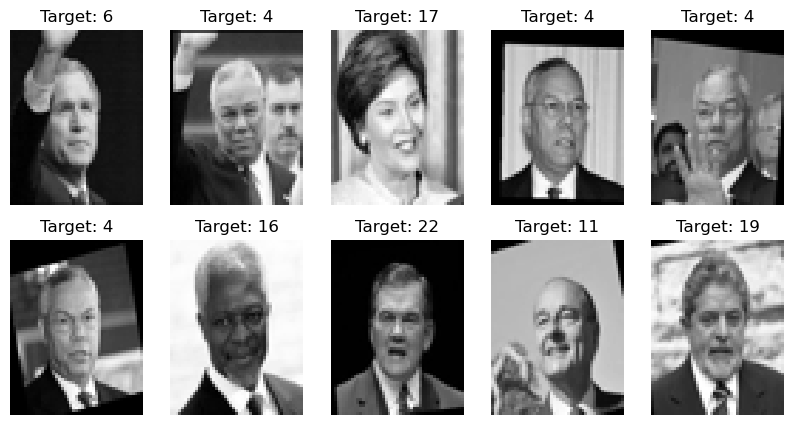

In [3]:
display_image_dataset(data)
# Standard machine learning pipelines that are not especially 
# designed for images, simply expect vectors as inputs, so let's
# flatten the image data for scikit-learn 
n_samples = len(data.images)
X = data.images.reshape((n_samples, -1))
y = data.target

## Task 1: Exploration - Analyze the class distribution of the dataset

How many classes are there? Is the dataset *imbalanced*? What is the most frequent class?
Use some code to answer these questions

In [9]:

unique, counts = np.unique(data.target, return_counts=True)
print(counts)



[ 39  35  36  77 236 121 530 109  44  39  71  52  55  42  53  60  32  41
  41  48  33  52  33 144  32  49]


## Task 2: Analyze the multi-class classifier

Let's first a define a classifier pipeline. Each aspect of the definition will be discussed in later lectures:

In [55]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA(n_components=256)),  # Adjust n_components to your needs
    ('knn', KNeighborsClassifier(n_neighbors=9))
])

Let's dive into some tasks and questions that need to be solved by your code:
1. Analyze the classifiers performance on 20% hold-out test data!
2. What is the cross-validation performance of it?
3. Is accuracy a good measure to use?
4. Draw a confusion matrix!
5. Bonus: Optimize the pipeline if you can :)

In [56]:
# Assuming X and y are your feature matrix and target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#TODO: gleichmäßige Gruppen einfügen und vergelcihen!!
# Train the pipeline on training data
pipeline.fit(X_train, y_train)

# Predict on the 20% hold-out test data
y_pred = pipeline.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on hold-out test data:", accuracy)



Accuracy on hold-out test data: 0.38004750593824227


In [57]:
# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=12, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

Cross-validation scores: [0.41843972 0.37588652 0.34751773 0.35       0.45714286 0.38571429
 0.31428571 0.31428571 0.42857143 0.36428571 0.38571429 0.34285714]
Average CV score: 0.37372509287402905


In [60]:
from sklearn.metrics import f1_score

# Assuming y_test are true labels and y_pred are predicted labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# If data is imbalanced, F1-score might be better
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
print("F1-score:", f1)

Accuracy: 38.00%
F1-score: 0.3477027769986013


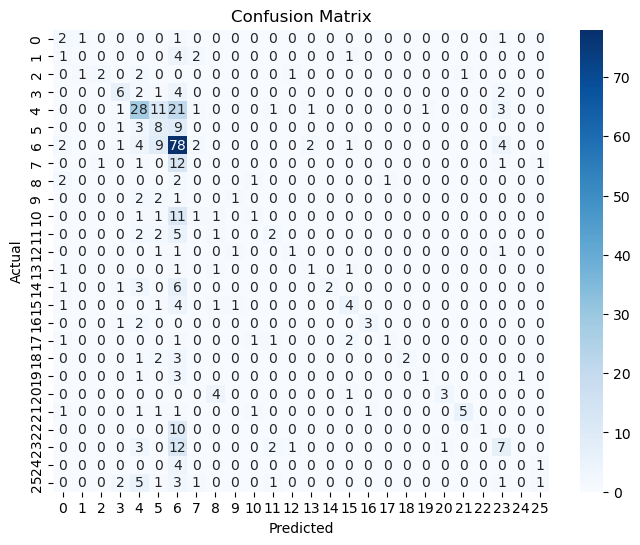

In [61]:
import seaborn as sns
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for KNN and PCA components
param_grid = {
    'pca__n_components': [128, 256, 1024],  # Test different numbers of PCA components
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 20, 30]    # Test different values of k
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on the hold-out test set with the optimized model
best_pipeline = grid_search.best_estimator_
y_pred_best = best_pipeline.predict(X_test)
print("Optimized Test Accuracy:", accuracy_score(y_test, y_pred_best))

Best Parameters: {'knn__n_neighbors': 9, 'pca__n_components': 256}
Best Cross-Validation Score: 0.37373180726296457
Optimized Test Accuracy: 0.37767220902612825


In [ ]:
from sklearn.metrics import classification_report

# Detaillierter Bericht mit Precision, Recall, F1 und Support pro Klasse
report = classification_report(y_test, y_pred, output_dict=True)

# Durchschnittliche Accuracy pro Klasse
for label, metrics in report.items():
    if label.isdigit():  # Überprüft, ob das Label eine Klasse ist (kein Durchschnitt)
        print(f"Klasse {label}:")
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-Score: {metrics['f1-score']:.2f}")
        print(f"  Anzahl der Instanzen: {metrics['support']}\n")

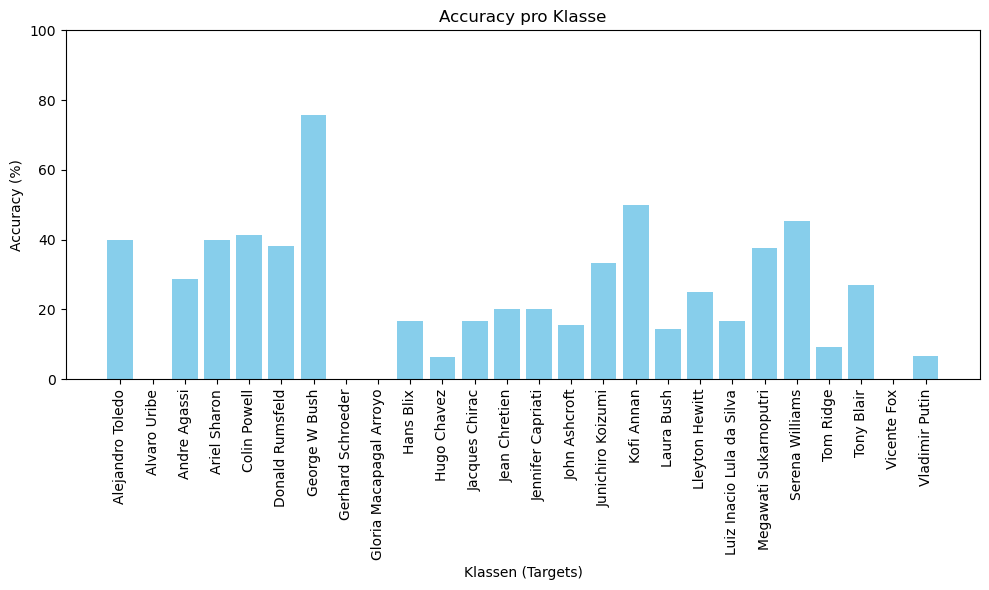

In [64]:
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Erstelle ein Histogramm der Accuracy pro Klasse
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(accuracy_per_class)), accuracy_per_class * 100, color='skyblue')

# X-Achsen-Beschriftungen setzen
plt.xticks(np.arange(len(accuracy_per_class)), data.target_names, rotation=90)

# Beschriftungen und Titel
plt.xlabel('Klassen (Targets)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy pro Klasse')
plt.ylim(0, 100)

# Zeige das Histogramm
plt.tight_layout()
plt.show()